In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
import cv2
import keras_tuner as kt
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10, fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/greg115/celebrities-100k'



(50000, 32, 32, 3)
(10000, 32, 32, 3)


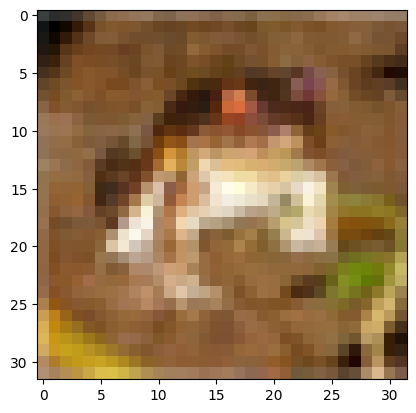

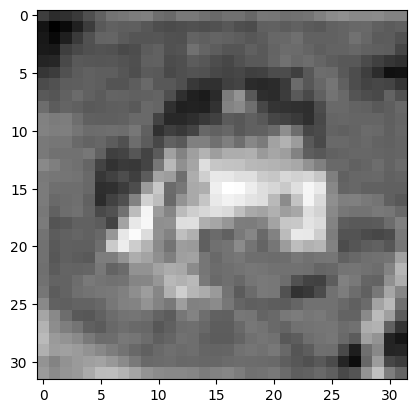

In [3]:
(train_y, _), (test_y, _) = cifar10.load_data()
print(train_y.shape)
print(test_y.shape)
plt.imshow(train_y[0])
plt.show()

train_x = np.reshape(np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in train_y]), (50000, 32, 32, 1))
test_x = np.reshape(np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in test_y]), (10000, 32, 32, 1))

plt.imshow(train_x[0], cmap='gray')
plt.show()

train_x = train_x.astype('float')
train_y = train_y.astype('float')
test_x = test_x.astype('float')
test_y = test_y.astype('float')

In [17]:
K.clear_session()
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(32, 32, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same')
        ])
        self.decoder = tf.keras.Sequential([
layers.InputLayer(input_shape=(8, 8, 64)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])


In [18]:
autoencoder.fit(train_x, train_y,epochs=1,
                shuffle=True,
                validation_data=(test_x, test_y), batch_size=32)

1563/1563 [==============================] - 101s 64ms/step - loss: 18445.3164 - accuracy: 0.5092 - val_loss: 18631.0762 - val_accuracy: 0.5084


In [19]:
results = autoencoder.predict(train_x)

1563/1563 [==============================] - 21s 14ms/step


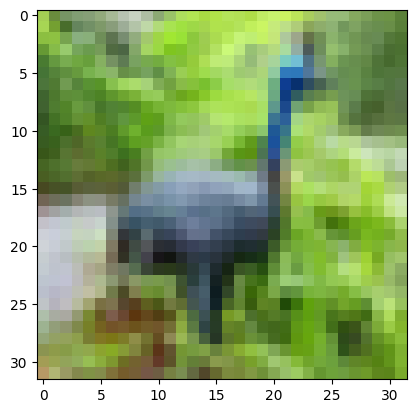

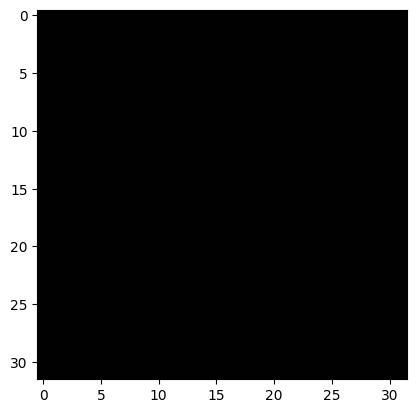

In [20]:
plt.imshow(train_y[6].astype(int))
plt.show()
plt.imshow(results[6].astype(int))
plt.show()

In [10]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                40606     
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         17635     
                                                                 
Total params: 58,241
Trainable params: 58,241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
K.clear_session()

class MomentumAutoencoder(Model):
    def __init__(self):
        super(MomentumAutoencoder, self).__init__()
    def build(self):
        model = tf.keras.Sequential()
        self.momentum = 0.99
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, 3, padding='same'),
            layers.Activation('relu'),
            layers.Conv2D(32, 3, padding='same', strides=2),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum),
            layers.Conv2D(64, 3, padding='same'),
            layers.Activation('relu'),
            layers.Conv2D(128, 3, padding='same', strides=2),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum),
            layers.Conv2D(256, 3, padding='same'),
            layers.Activation('relu'),
            layers.Conv2D(128, 3, padding='same', strides=2),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum),
            layers.Conv2D(256, 3, padding='same'),
            layers.Activation('relu'),
            layers.Conv2D(128, 3, padding='same'),
            layers.Activation('relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(256, 3, padding='same'),
            layers.Activation('relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(128, 3, padding='same'),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(64, 3, padding='same'),
            layers.Activation('relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, 3, padding='same'),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum),
            layers.Conv2D(16, 3, padding='same'),
            layers.Activation('relu'),
            layers.Conv2D(3, 3, padding='same'),
            layers.Activation('relu'),
            layers.BatchNormalization(momentum=self.momentum)
        ])
        model.add(self.encoder)
        model.add(self.decoder)
        model.compile(optimizer='adam', loss='mse')
        return model

autoencoder = MomentumAutoencoder().build()

In [ ]:
autoencoder.fit(train_x, train_y,epochs=11,
                shuffle=True,
                validation_data=(test_x, test_y), batch_size=1)

Epoch 1/11
391/391 [==============================] - 654s 2s/step - loss: 18507.4668 - val_loss: 11141.5684
Epoch 2/11
269/391 [===================>..........] - ETA: 2:46 - loss: 18390.4941

KeyboardInterrupt: 